In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import sys

In [2]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
l=[6562.8,6548,6583,6717,6731]#AngstromsR
#l=[4861.36,4958.9,5006.9]#AngstromsB
#LimitData
min0=65
max0=145

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

In [3]:
inputf='604.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})

mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

In [4]:
for i in 0,2:
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-l[Nx])/l[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('data'+str(int(l[Nx]))+'.csv')


In [5]:
datap='data6562.csv'

In [6]:
Ha=pd.read_csv(datap)
Ha=Ha.rename(columns={'Unnamed: 0':'No'})
Ha=Ha.drop('No',axis=1)
os.remove(datap)
Ha.describe()

,X,Y,RV,I
count,600.000000,600.000000,600.000000,600.000000
mean,105.269000,9.390000,-250.043594,2277.239467
std,23.243169,6.256047,10.420092,3750.107456
min,65.710000,0.000000,-277.593319,27.150000
25%,85.485000,4.000000,-257.836471,281.925000
50%,105.270000,9.000000,-249.888052,1017.500000
75%,125.045000,15.000000,-244.018098,2403.500000
max,144.830000,19.600000,-205.463695,30960.000000


In [7]:
#acf

In [8]:
data=Ha.copy()

pc=1.0
 
df1=data
df1n=df1.to_numpy()

xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

In [9]:
sig2=2*(data.RV.var())#Change to header
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

f=f-np.nanmean(f)


In [10]:
a=[[0]*(l) for i in range(l)]#MatrixForStatisticalFunctionComputation
b=[[0]*(l) for i in range(l)]#Matrix of Separations-Lags
c=[[0]*(2) for i in range(l*l)]#Main Matrix [a,b]

#Normalized autocorrelation Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(f[j][0]*f[i][0])/fv
                

#Coord Matrix [LxL]
for i in range (l):
    for j in range (l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5

#LxL to Lx2
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]


In [11]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,0])>0
e=d[ind]
#Pandas Stuff
df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,179700.000000,179700.000000
mean,28.993103,-0.001667
std,17.837259,0.996096
min,1.340000,-11.311318
25%,14.667409,-0.329834
50%,25.446611,-0.000516
75%,41.359556,0.328431
max,81.511560,17.253233


/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


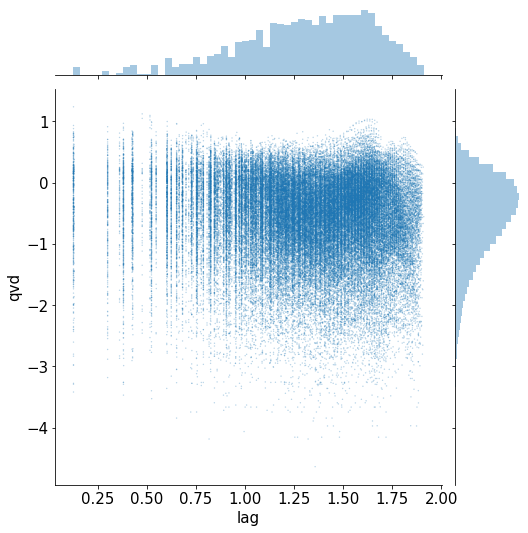

In [12]:
ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
ax.fig.set_size_inches(8,8)

In [13]:
#Main Filter Group
m=df.lag[0]#Lag step
n=int(df.lag.max()//df.lag.min())-1#Number of points
#Grouping points
dfx=dict()

for i in range(n):
    p=0+i*(m+0.001)#rs
    q=m+i*m
    dfx[i]=df[df['lag'].between(p,q)]

In [14]:
dfx 

{0:          lag       qvd
 0       1.34  0.003703
 599     1.34 -0.007975
 1197    1.34  0.261125
 2390    1.34  4.744015
 2985    1.34  6.457062
 ...      ...       ...
 179685  1.34  6.185254
 179690  1.34  6.374064
 179694  1.34  6.329946
 179697  1.34  6.109353
 179699  1.34  5.502575
 
 [530 rows x 2 columns], 1:              lag       qvd
 1       2.680000 -0.032229
 59      2.300000  0.096482
 60      2.661879  0.049288
 600     2.680000 -0.030004
 657     2.661879  0.023874
 ...          ...       ...
 179679  1.350000  5.650109
 179686  2.680000  6.142442
 179691  2.680000  6.374064
 179695  2.680000  6.109353
 179698  2.680000  5.701258
 
 [1944 rows x 2 columns], 2:              lag       qvd
 2       4.020000 -0.121253
 61      3.531629 -0.008095
 660     3.531629 -0.053360
 1198    2.690000  0.511747
 1254    3.531629 -0.207779
 ...          ...       ...
 179673  2.690000  5.746435
 179680  2.690000  5.863166
 179687  4.020000  6.142442
 179692  4.020000  6.151934
 17969

Main Matrix Statistical Properties Groups

In [15]:
lgp=dict()
lpc=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    lpc[i]=lgp[i]*pc
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/np.sqrt(dl[i]-1)
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/np.sqrt(dl[i]-1)  


g=[[0]*(8) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=dfs[i]
    g[i][4]=dfv[i]
    g[i][5]=lpc[i]
    g[i][6]=dl[i]
    g[i][7]=derx[i]



In [16]:
af=pd.DataFrame(g)
af.columns=['Lag','Nmqvd','ErrY','ErrX','StD','Var','Lag pc','# P']
af.loc[-1]=[0,1,0,0,0,0,0,1]
af.index=af.index+1
af.sort_index(inplace=True)

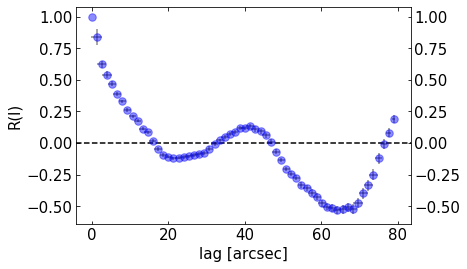

In [17]:
fig, ax=plt.subplots()
ax.errorbar(af['Lag'],af['Nmqvd'],xerr=af.ErrX,yerr=af.ErrY, fmt="o",color='b', ecolor='k', alpha=0.45, markersize=7.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set(xlabel='lag [arcsec]', ylabel=r'R(l)')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid(which='minor')
